## Group 33

- Alexandre Gonçalves (20240738)
- Bràulio Damba (20240007)
- João Henriques (20240499)
- Mariana Sousa (20240516)
- Victoria Goon (20240550)

### 1 - Mount and Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/data.zip" , "r")

zip_ref.extractall("/content/data")

zip_ref.close()

In [3]:
import os

In [4]:
# Change the working directory to the correct folder
os.chdir('/content/drive/MyDrive/Colab Notebooks')

print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/Colab Notebooks


In [5]:
ls

 data.zip
 DL_HyperparameterOptimization_Xception_NoAug_WithoutOutliers_WithOversamplying.ipynb
 EDA_Preprocessing.ipynb
 Library/
 model_logs/
'Other Architectures'/
 VGG16/


In [6]:
import os
import shutil
import json
import pickle
from pathlib import Path
from datetime import datetime
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from Library.utils import get_callbacks, oversample_adaptive_r5075100, get_all_relative_image_paths


import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import (Input, Dense, Dropout, GlobalAveragePooling2D, Rescaling, RandomFlip, RandomRotation, RandomContrast, RandomTranslation,Conv2D, MaxPooling2D, Flatten)
from keras.utils import img_to_array, load_img, to_categorical, image_dataset_from_directory
from keras.applications import Xception
from keras.optimizers import Adadelta, Adagrad, Adam, RMSprop, SGD, Adamax, Nadam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, F1Score, Precision, Recall
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger

from pathlib import Path


### 2 - Dataset split

In [8]:
metadata = pd.read_csv('/content/data/data/original/source_images/metadata.csv')
# Get all relative image paths from images that remained after manual outlier removal
cleaned_unsplit_path = '/content/data/data/outliers_removed_manual/cleaned_unsplit'

# Get all relative image paths from cleaned unsplit directory
relative_paths = get_all_relative_image_paths(cleaned_unsplit_path)

# Create new metadata file after filter from original metadata images removed mannualy
mask = metadata['file_path'].isin(relative_paths)
metadata_outl_manual = metadata[mask]

print(f"Images in cleaned metadata: {len(metadata_outl_manual)}")

Images in cleaned metadata: 10978


In [9]:
# Using stratify to maintain the distribution of classes in the train, validation, and test sets
train_df, val_test_df = train_test_split(metadata_outl_manual, test_size=0.3, stratify=metadata_outl_manual['family'], random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df['family'], random_state=42)


In [10]:
def move_images(df, folder_name, original_base_dir, target_base_dir):
    for _, row in df.iterrows():
        src_path = os.path.join(original_base_dir, row['file_path'])  # e.g., "arthropoda_apidae/image1.jpg"
        subfolder = os.path.dirname(row['file_path'])  # e.g., "arthropoda_apidae"
        dst_dir = os.path.join(target_base_dir, folder_name, subfolder)
        dst_path = os.path.join(dst_dir, os.path.basename(src_path))

        os.makedirs(dst_dir, exist_ok=True)

        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"Missing file: {src_path}")

In [11]:
# Set the base directory for the original images (inside source images folder)
original_base_dir = '/content/data/data/outliers_removed_manual/cleaned_unsplit'

# Set the base directory for the destination folders
target_base_dir = '/content/data/data/outliers_removed_manual'

# Create directories for each split
os.makedirs(os.path.join(target_base_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(target_base_dir, 'validation'), exist_ok=True)
os.makedirs(os.path.join(target_base_dir, 'test'), exist_ok=True)

# Move images to their corresponding folders
move_images(train_df, 'train', original_base_dir, target_base_dir)
move_images(val_df, 'validation', original_base_dir, target_base_dir)
move_images(test_df, 'test', original_base_dir, target_base_dir)

In [12]:
# Create train_oversampled_adaptive_r5075100 directory inside outliers_removed_manual

# Step 1: Define paths
input_dir = '/content/data/data/outliers_removed_manual/train'
output_dir = '/content/data/data/outliers_removed_manual/train_oversampled_adaptive_r5075100'

# Step 2: Set the size of the largest class (you can calculate this)
max_image_count = 204  # Obtained in the EDA_Preprocessing notebook

# Step 3: Call the function
oversample_adaptive_r5075100(input_dir, max_image_count, output_dir)

# Time: 13 minutes

### 3 - Training

In [13]:
n_classes = 202

In [14]:
# CHANGE ONLY HERE
model_name = "Xception"
epochs = 500
resolution = 299 #Specific for Xception
batch_size = 64
n_classes = 202
augmentation = False

In [15]:
train_data = image_dataset_from_directory(
    Path("/content/data/data/outliers_removed_manual/train_oversampled_adaptive_r5075100"),
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(resolution,resolution)
)

Found 17901 files belonging to 202 classes.


In [16]:
val_data = image_dataset_from_directory(
    Path("/content/data/data/outliers_removed_manual/validation"),
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(resolution,resolution)
)

Found 1647 files belonging to 202 classes.


In [17]:
test_data = image_dataset_from_directory(
    Path("/content/data/data/outliers_removed_manual/test"),
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(resolution,resolution)
)

Found 1647 files belonging to 202 classes.


In [24]:
# Main paper source: https://thesai.org/Publications/ViewPaper?Volume=14&Issue=4&Code=IJACSA&SerialNo=92
# Secondary paper source: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9725112&tag=1
# Other sources: https://keras.io/keras_tuner/
def build_tunable_Xception_classifier(hp):
    input_shape = (resolution, resolution, 3)
    num_classes = n_classes

    # Hyperparameters that we want to rune and respective search space. They are all paper backed
    optimizer_name = hp.Choice("optimizer", values=['Adam', 'RMSprop', 'SGD', 'Adamax'])
    learning_rate = hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3])
    dropout_rate = hp.Choice("dropout_rate", values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    activation_value = hp.Choice("activation_function", values=['relu', 'tanh', 'softsign'])
    dense_units = hp.Choice("dense_units", values=[128, 256, 512, 1024])

    # Define preprocessing block as we have been doing so far
    preprocess_block = Sequential(name="augmentation_pipeline")
    preprocess_block.add(Rescaling(1./255))

    input_tensor = Input(shape=input_shape, name="input_image")
    x = preprocess_block(input_tensor)

    base_model = Xception(include_top=False, weights='imagenet', input_tensor=x)
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(dense_units, activation=activation_value)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units, activation=activation_value)(x)
    x = Dropout(dropout_rate)(x)
    output_tensor = Dense(num_classes, activation='softmax', name="output_probs")(x)

    model = Model(inputs=input_tensor, outputs=output_tensor, name="Tuned_Xception_Classifier")

    # Set optimizer with tuned learning rate
    optimizers = {
        "Adam": Adam(learning_rate=learning_rate),
        "RMSprop": RMSprop(learning_rate=learning_rate),
        "SGD": SGD(learning_rate=learning_rate),
        "Adamax": Adamax(learning_rate=learning_rate)
}

    optimizer = optimizers[optimizer_name]

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss=CategoricalCrossentropy(name="loss"),
        metrics=[
            CategoricalAccuracy(name="accuracy"),
            F1Score(average="macro", name="f1_score"),
            Precision(),
            Recall()
        ]
    )

    return model


In [25]:
# Timestamp to uniquely identify run
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# File paths
base_dir = Path("model_logs") / "Xception"
base_dir.mkdir(parents=True, exist_ok=True)

checkpoint_path = base_dir / f"DL_Xception_HyperparameterTunning_checkpoint_{timestamp}.keras"
metrics_path = base_dir / f"DL_Xception_HyperparameterTunning_metrics_{timestamp}.csv"


# Defining more approriate callbacks for hyperparameter tunning

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,  # Increased from 3 to 10
    restore_best_weights=True,
    verbose=1
)


def exp_decay_lr_scheduler(
    epoch: int,
    current_lr: float,
    factor: float = 0.95
) -> float:
    """
    Exponential decay learning rate scheduler
    """

    current_lr *= factor

    return current_lr

lr_scheduler_callback = LearningRateScheduler(exp_decay_lr_scheduler)

csv_logger = CSVLogger(metrics_path)

# Final list
callbacks = [checkpoint_callback, csv_logger, lr_scheduler_callback, early_stopping]



In [21]:
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [26]:
from keras_tuner import Hyperband, BayesianOptimization
from keras_tuner import Objective


model_tuner = BayesianOptimization(
    hypermodel=build_tunable_Xception_classifier,
    objective=Objective("val_f1_score", direction="max"),  # Or 'val_accuracy' if you prefer
    max_trials=10,  # Paper backed: "Number of Epochs of Each Model and Hyperband's Classification Performance"
    directory=str(base_dir),
    project_name='Xception_hparam_tuning_bayesian'
)

In [27]:
# Run the search
model_tuner.search(
    train_data,
    epochs=200,
    validation_data=val_data,
    callbacks=callbacks
)

Trial 10 Complete [00h 22m 15s]
val_f1_score: 0.6917139887809753

Best val_f1_score So Far: 0.6960288286209106
Total elapsed time: 05h 39m 10s


In [28]:
from IPython.display import Javascript
Javascript('''google.colab.kernel.invokeFunction("notebook.run_cells_below")''')

<IPython.core.display.Javascript object>

### 4. Evaluating best model obtained




In [38]:
# Best values for each hyperparameter included in the tunning process
best_hyperparamaters = model_tuner.get_best_hyperparameters(1)[0]

In [39]:
# Best value for each hyperparameter
print("Best optimizer:", best_hyperparamaters.get('optimizer'))
print("Best learning rate:", best_hyperparamaters.get('learning_rate'))
print("Best dropout rate:", best_hyperparamaters.get('dropout_rate'))
print("Best activation function:", best_hyperparamaters.get('activation_function'))
print("Best dense units:", best_hyperparamaters.get('dense_units'))

Best optimizer: SGD
Best learning rate: 0.1
Best dropout rate: 0.1
Best activation function: tanh
Best dense units: 1024


In [40]:
# Print best Hyperparameters
print(best_hyperparamaters.values)

{'optimizer': 'SGD', 'learning_rate': 0.1, 'dropout_rate': 0.1, 'activation_function': 'tanh', 'dense_units': 1024}


In [41]:
# Build the best model and retrain it
best_Xception_model = model_tuner.hypermodel.build(best_hyperparamaters)
training_history = best_Xception_model.fit(
    train_data,
    epochs=300,
    validation_data=val_data,
    callbacks=callbacks
)

Epoch 1/300
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.2532 - f1_score: 0.1765 - loss: 3.9429 - precision_3: 0.7282 - recall_3: 0.0317
Epoch 1: val_loss improved from inf to 1.65545, saving model to model_logs/Xception/DL_Xception_HyperparameterTunning_checkpoint_20250421_1746.keras
280/280 ━━━━━━━━━━━━━━━━━━━━ 60s 184ms/step - accuracy: 0.2537 - f1_score: 0.1770 - loss: 3.9395 - precision_3: 0.7289 - recall_3: 0.0319 - val_accuracy: 0.5920 - val_f1_score: 0.4952 - val_loss: 1.6555 - val_precision_3: 0.9108 - val_recall_3: 0.2914 - learning_rate: 0.0950
Epoch 2/300
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6500 - f1_score: 0.6107 - loss: 1.4930 - precision_3: 0.9228 - recall_3: 0.3338
Epoch 2: val_loss improved from 1.65545 to 1.34161, saving model to model_logs/Xception/DL_Xception_HyperparameterTunning_checkpoint_20250421_1746.keras
280/280 ━━━━━━━━━━━━━━━━━━━━ 42s 148ms/step - accuracy: 0.6500 - f1_score: 0.6109 - loss: 1.4926 - precision_3: 0.9228 - rec

In [42]:
# Save model results
best_Xception_model.save(base_dir / "DL_Xception_final_model.keras")

In [43]:
# Evaluate model results
test_results = best_Xception_model.evaluate(test_data, return_dict=True, verbose = 1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.7399 - f1_score: 0.6114 - loss: 1.0690 - precision_3: 0.8454 - recall_3: 0.6728


In [44]:
# Classification report
y_true = []
y_pred = []
class_names = train_data.class_names

for images, labels in test_data:
    preds = best_Xception_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 1.0661729574203491
Test Accuracy: 0.7383120656013489


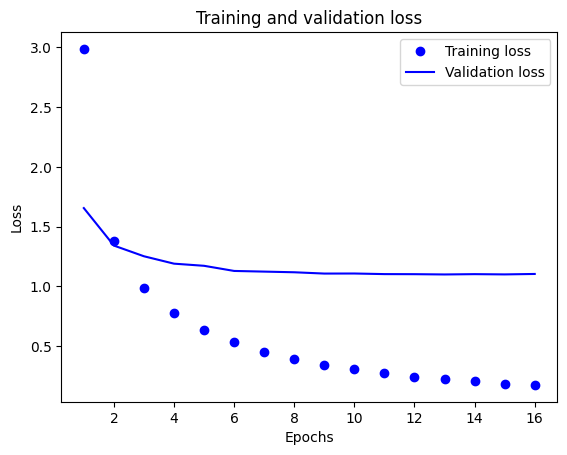

In [45]:
# Print evaluation results
print("Test Loss:", test_results['loss'])
print("Test Accuracy:", test_results['accuracy'])

# Step 3: Plot the loss
loss = training_history.history['loss']
val_loss = training_history.history['val_loss']
epochs_range = range(1, len(loss) + 1)

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

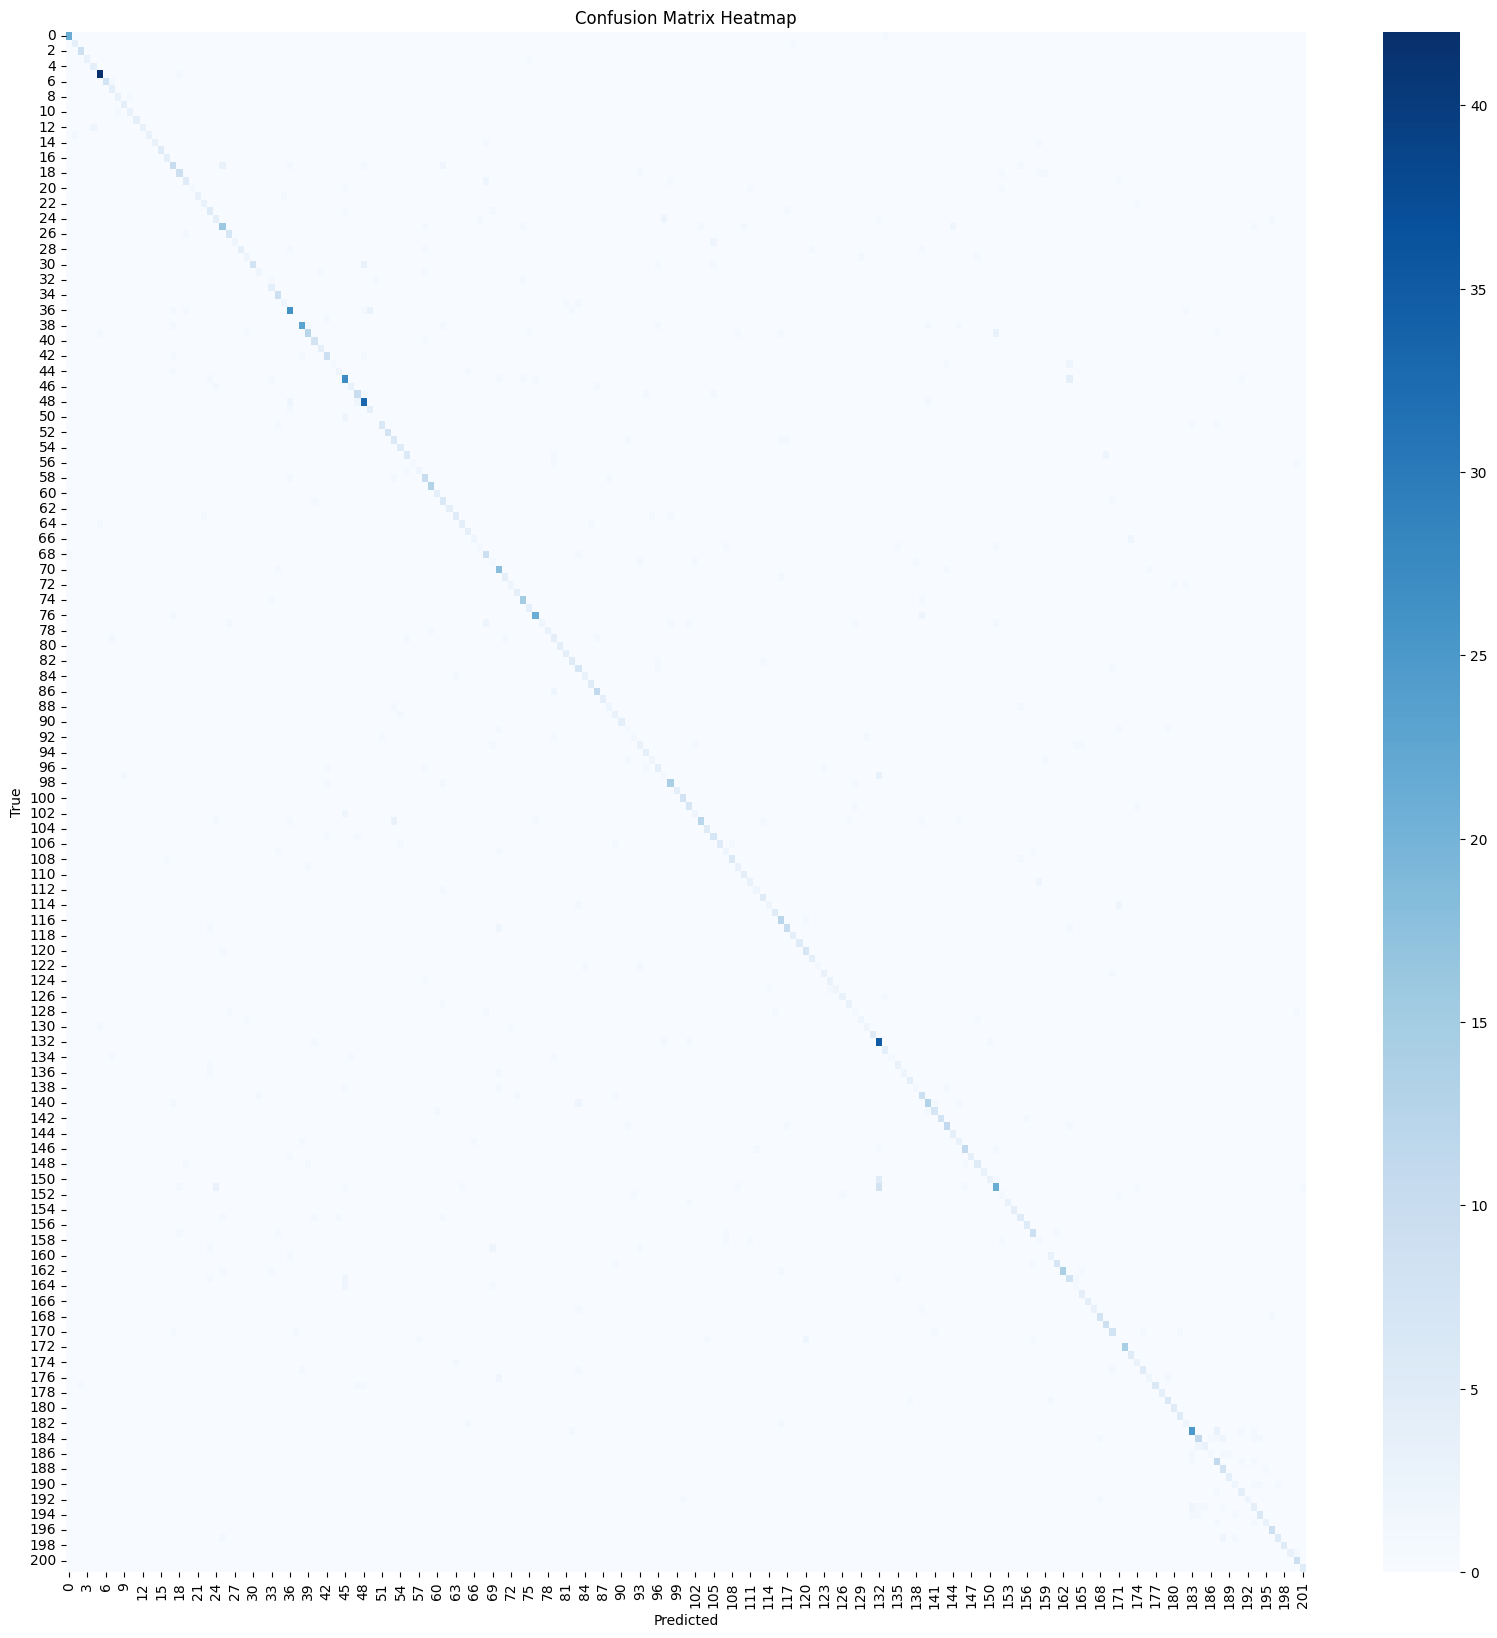

In [46]:
# Confusion matrix

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 20))  # Make it very large
sns.heatmap(cm, cmap='Blues')
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [47]:
# Confusion matrix


# Assume y_true and y_pred already contain the true and predicted class indices
# Convert to binary: 1 if correct, 0 if wrong
binary_true = np.ones_like(y_true)  # "truth" is 1 (correct prediction)
binary_pred = (np.array(y_true) == np.array(y_pred)).astype(int)

# Compute confusion matrix
cm = confusion_matrix(binary_true, binary_pred, labels=[1, 0])

# Format into TP, FN, FP, TN
TP = cm[0, 0]
FN = cm[0, 1]
FP = cm[1, 0]
TN = cm[1, 1]

# Print matrix manually like your diagram
print("Confusion Matrix (Correct vs Incorrect):\n")
print(f"               Predicted P    Predicted N")
print(f"True P     {TP:>10}    {FN:>10}")
print(f"True N     {FP:>10}    {TN:>10}")

Confusion Matrix (Correct vs Incorrect):

               Predicted P    Predicted N
True P           1216           431
True N              0             0


In [48]:
# Number of corrent vs incorrect predictions
correct_predictions = np.array(y_true) == np.array(y_pred)
num_correct = np.sum(correct_predictions)
num_incorrect = len(y_true) - num_correct

print("\nCorrect vs Incorrect Predictions")
print(f"Correct predictions:   {num_correct}")
print(f"Incorrect predictions: {num_incorrect}")


Correct vs Incorrect Predictions
Correct predictions:   1216
Incorrect predictions: 431


In [49]:
# Top 10 Most Misclassified Classes

# source: https://www.geeksforgeeks.org/counters-in-python-set-1/
from collections import Counter

# Assuming you already have these
# y_true: list of true class indices
# y_pred: list of predicted class indices
# class_names: list of class names in the same order as model output (e.g., ['Mollusca_Littorinidae', ...])

# Step 1: Identify which predictions were incorrect
y_true = np.array(y_true)
y_pred = np.array(y_pred)
errors = y_true != y_pred

# Step 2: Extract misclassified true class indices
misclassified_true_labels = y_true[errors]

# Step 3: Count how often each true class was misclassified
misclassified_counts = Counter(misclassified_true_labels)

# Step 4: Convert to DataFrame for better visualization
misclassified_df = pd.DataFrame({
    "class_index": list(misclassified_counts.keys()),
    "misclassified_count": list(misclassified_counts.values())
})

# Map class indices to class names
misclassified_df["class_name"] = misclassified_df["class_index"].map(lambda i: class_names[i])

# Step 5: Get Top 10 most misclassified classes
top_10_misclassified = misclassified_df.sort_values(by="misclassified_count", ascending=False).head(10)

# Show result
print(top_10_misclassified[["class_name", "misclassified_count"]])


                  class_name  misclassified_count
7     chordata_salamandridae                   18
62          chordata_laridae                   10
22   chordata_carcharhinidae                   10
9         chordata_bufonidae                    9
11          chordata_bovidae                    8
27     chordata_accipitridae                    8
29  chordata_diplodactylidae                    7
1       cnidaria_agariciidae                    7
72         chordata_anatidae                    7
18      chordata_bucerotidae                    6


### 5. Visualize incorrect predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


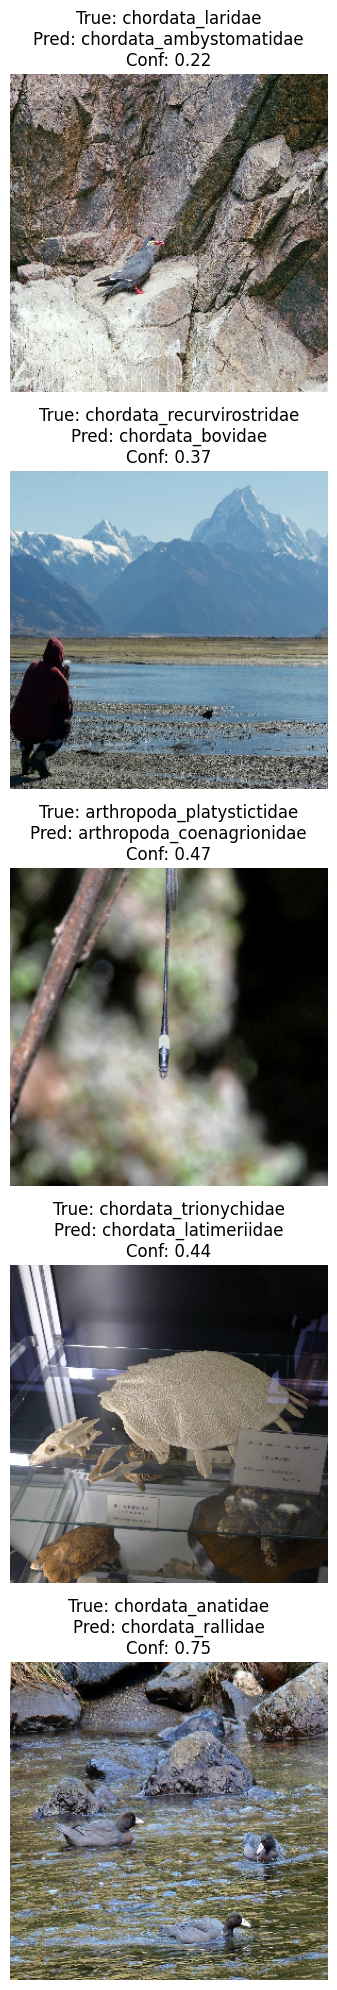

In [53]:
# Visualize incorrect predictions

import matplotlib.pyplot as plt
import numpy as np

# Store incorrect predictions
incorrect_images = []
incorrect_preds = []
incorrect_true = []
incorrect_confidences = []

# Collect incorrect predictions
for images, labels in test_data:
    preds = best_Xception_model.predict(images)
    y_true_batch = np.argmax(labels.numpy(), axis=1)
    y_pred_batch = np.argmax(preds, axis=1)

    for i in range(len(images)):
        if y_true_batch[i] != y_pred_batch[i]:
            incorrect_images.append(images[i])
            incorrect_preds.append(y_pred_batch[i])
            incorrect_true.append(y_true_batch[i])
            incorrect_confidences.append(np.max(preds[i]))


# Plot first 5 incorrect predictions, one per row
plt.figure(figsize=(5, 20))  # Taller figure for vertical stacking
for i in range(5):
    ax = plt.subplot(5, 1, i + 1)  # 5 rows, 1 column
    plt.imshow(incorrect_images[i].numpy().astype("uint8"))
    plt.title(f"True: {class_names[incorrect_true[i]]}\nPred: {class_names[incorrect_preds[i]]}\nConf: {incorrect_confidences[i]:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()


### 6. Saving important variables

In [55]:
from pathlib import Path
from datetime import datetime
import json
import pickle
import numpy as np

# Timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# Create base directory + subdirectory for Xception
base_dir = Path("model_logs") / "Xception"
base_dir.mkdir(parents=True, exist_ok=True)

# Define file paths
checkpoint_path = base_dir / f"DL_Xception_HyperparameterTunning_checkpoint_{timestamp}.keras"
metrics_path = base_dir / f"DL_Xception_HyperparameterTunning_metrics_{timestamp}.csv"
hyperparams_path = base_dir / f"best_hyperparameters_{timestamp}.json"
test_results_path = base_dir / f"test_results_{timestamp}.json"
y_true_path = base_dir / f"y_true_{timestamp}.npy"
y_pred_path = base_dir / f"y_pred_{timestamp}.npy"
history_path = base_dir / f"training_history_{timestamp}.pkl"

# Save model
best_Xception_model.save(checkpoint_path)

# Save best hyperparameters
with open(hyperparams_path, "w") as f:
    json.dump(best_hyperparamaters.values, f)

# Save test results
with open(test_results_path, "w") as f:
    json.dump(test_results, f)

# Save true/pred labels
np.save(y_true_path, y_true)
np.save(y_pred_path, y_pred)

# Save training history
with open(history_path, "wb") as f:
    pickle.dump(training_history.history, f)
